In [3]:
import xarray
import fsspec
import numpy as np
#import s3fs
import proplot
import os

from matplotlib import pyplot as plt
import pandas
import gsw as TEOS_10
import numpy as np


In [27]:
def Get_CODA_id(dates,source_data,obs_platform,year):
    
    CODA_id_length = 20
    CODA_ID = np.array(['' for _ in range(dates.size)], dtype='S{}'.format(CODA_id_length))
    
    unique_dates = np.unique(CODA_dates)

    
    for i_date in unique_dates:
    
        if not pandas.isnull(i_date):
            
            idx_for_date   =  np.nonzero(dates == i_date)[0]
            count_for_date =  idx_for_date.size
            i_profile = 1
            
            for i_index in idx_for_date:
                #print(i_index)
                CODA_id_current_profiles = source_data + obs_platform + i_date.strftime('%Y%m%d') + f'{i_profile:04}'
                CODA_ID[i_index] = CODA_id_current_profiles
                i_profile = i_profile+1
                
            #END for i_index
        #if not isnull
    #END for i_date

    bad_dates_idx = np.nonzero(pandas.isnull(dates))[0]
 
    bad_profile_counter = 1
    
    for i_bad_idx in bad_dates_idx:
        CODA_id_current_profiles = source_data + obs_platform + str(year) + 'XXXX' + f'{bad_profile_counter:04}'
        CODA_ID[i_bad_idx] = CODA_id_current_profiles
        bad_profile_counter = bad_profile_counter+1

    return CODA_ID

In [4]:
#Get list of netcdf files
ran_base_dir = '/oa-decadal-climate/work/observations/CARSv2_ancillary/data_originator/RANCTD'

ran_ctd_files = os.listdir(ran_base_dir)

ran_ctd_files_to_get = []
for i_file in ran_ctd_files:
    
    if os.path.isfile(os.path.join(ran_base_dir,i_file)) and os.path.join(ran_base_dir,i_file).endswith('.nc'):
        ran_ctd_files_to_get.append(os.path.join(ran_base_dir,i_file))

ran_ctd_files_to_get.sort()        

In [19]:
xarray.open_dataset(ran_ctd_files_to_get[2])

<xarray.Dataset>
Dimensions:                         (pressure: 24)
Coordinates:
    time                            datetime64[ns] ...
    latitude                        float64 ...
    longitude                       float64 ...
  * pressure                        (pressure) float64 5.0 6.0 7.0 ... 27.0 28.0
Data variables:
    time_qc_flag                    int8 ...
    position_qc_flag                int8 ...
    temperature                     (pressure) float64 ...
    temperature_whole_profile_flag  int8 ...
    temperature_qc_flag             (pressure) int8 ...
    temperature_sd_test             (pressure) int8 ...
    salinity                        (pressure) float64 ...
    salinity_whole_profile_flag     int8 ...
    salinity_qc_flag                (pressure) int8 ...
    salinity_sd_test                (pressure) int8 ...
    profile                         int32 ...
Attributes: (12/43)
    Conventions:                  CF-1.6
    featureType:                  profile
    title:                        RAN CTD data Ship: HMAS Melville Cruise: HI...
    summary:                      This file contains a vertical profile of pr...
    keywords:                     Oceans | Ocean Temperature | Water Temperat...
    id:                           82af84eb-e0d1-4095-bdee-0a6943a7d03f
    ...                           ...
    CTD_MinRawPressure:           4.12
    CTD_MaxRawPressure:           28.33
    CTD_MinPressureforInterp:     4.12
    CTD_MaxPressureforInterp:     28.33
    CTD_cast_direction:           Down
    CTD_scan_rate:                1.83 Hz

In [7]:
ctd_time = np.zeros(len(ran_ctd_files_to_get),'datetime64[ns]')

file_counter = 0
for i_file in ran_ctd_files_to_get:
    ctd_dataset = xarray.open_dataset(i_file)
    ctd_time[file_counter]    = ctd_dataset['time'].values
    ctd_dataset.close()
    file_counter = file_counter+1
    

ran_ctd_files_to_get_sorted = []


time_sorted_idx = np.argsort(ctd_time)

for i_index in time_sorted_idx:
    ran_ctd_files_to_get_sorted.append( ran_ctd_files_to_get[i_index])
    
ctd_time             = ctd_time[time_sorted_idx]
years = ctd_time.astype('datetime64[Y]').astype(int) + 1970
unique_years = np.unique(years)

In [8]:
unique_years

array([2000, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013,
       2014, 2015, 2016])

In [9]:
CODA_to_RAN_key = {'Temperature':'temperature',
                   'Salinity':'salinity',
                   'z':'pressure',
                    'latitude':'latitude',
                   'longitude':'longitude',
                   'time':'time'}  


In [37]:
output_path = '/oa-decadal-climate/work/observations/CARSv2_ancillary/CODA/WOD_CODA_test_v2'

hard_code_output = {'country':'Australia',
                    'dbase_orig':'AODN',
                    'Institute':'Royal Australian Navy'}

            



WOD_CODA_reference_file_name = '/oa-decadal-climate/work/observations/CARSv2_ancillary/CODA/WOD_CODA_test_v2/2015/WOD_CODA_2015_ctd_test_all_vars.nc'
WOD_CODA_reference_dataset   = xarray.open_dataset(WOD_CODA_reference_file_name)

vars_to_get = ['z','Temperature','Salinity']
ancillary_vars_to_get = ['Platform','Project','RAN_id','Temperature_Instrument']
FILL_VALUE = -10000000000.0


for i_year in unique_years[1::]:
    print(i_year)
    vars_to_get_for_platform = []
    
            
    idx_for_year = np.nonzero(years==i_year)[0]
    n_profiles   = idx_for_year.size

    
    max_depth_levels = 0
    
    for i_file_for_year in idx_for_year:
        ctd_dataset = xarray.open_dataset(ran_ctd_files_to_get_sorted[i_file_for_year])
        current_row_size = ctd_dataset[CODA_to_RAN_key['z']].size
        
        if current_row_size>max_depth_levels:
            max_depth_levels = current_row_size
        ctd_dataset.close()
    #END for i_file_for_year
    
    
    
    data_container_for_year            = {}
    attributes_data_container_for_year = {}
    attribute_container_for_year       = {}

    for i_var in vars_to_get:
        data_container_for_year[i_var]               = np.nan*np.zeros([n_profiles,max_depth_levels],dtype='float32')
        data_container_for_year[i_var + '_origflag'] = np.nan*np.zeros([n_profiles,max_depth_levels],dtype='int16')
        attribute_container_for_year[i_var]          = {}
    
    data_container_for_year['lat']  = np.nan*np.zeros([n_profiles],dtype='float32')
    data_container_for_year['lon']  = np.nan*np.zeros([n_profiles],dtype='float32')
    data_container_for_year['time'] = np.zeros([n_profiles],dtype='datetime64[ns]')
    
    attribute_container_for_year['lat'] = {}
    attribute_container_for_year['lon'] = {}
    attribute_container_for_year['time'] = {}

    
    ancillary_var_data_container_for_year = {}
    
    for i_ancillary_var in ancillary_vars_to_get:
        data_container_for_year[i_ancillary_var] =  np.zeros([n_profiles],dtype='S{}'.format(100))
        attribute_container_for_year[i_ancillary_var] = {}
    
    
    
    files_used_for_year = ' '

    cast_counter = 0
    for i_file_for_year in idx_for_year:
        
        #rint(mnf_ctd_files_to_get_sorted[i_file_for_year])
        current_file_name = os.path.basename(ran_ctd_files_to_get_sorted[i_file_for_year])
        
        ctd_dataset = xarray.open_dataset(ran_ctd_files_to_get_sorted[i_file_for_year])
        files_used_for_year = files_used_for_year + ' ' + os.path.basename(ran_ctd_files_to_get_sorted[i_file_for_year])
        
        
        for i_var in vars_to_get:
            
            i_var_name = CODA_to_RAN_key[i_var]
            variables_in_dataset = ctd_dataset.variables.keys()
            
            if i_var_name in variables_in_dataset:
                
                current_profile = ctd_dataset[i_var_name].values
                if i_var == 'z':
                    current_profile = TEOS_10.z_from_p(current_profile,ctd_dataset['latitude'].values)
                #END if i_var == z
                
                data_container_for_year[i_var][cast_counter,0:current_profile.size] = current_profile
            #END if i_mnf_var_name in  variables_in_dataset
            
            
            if i_var_name +  '_qc_flag' in variables_in_dataset:
                
                current_QC_profile = ctd_dataset[i_var_name + '_qc_flag' ].values
                data_container_for_year[i_var + '_origflag'][cast_counter,0:current_QC_profile.size] = current_QC_profile

            #END if i_var
            
            if cast_counter==0:
                variable_attributes = WOD_CODA_reference_dataset[i_var].attrs.keys()
                
                for i_attribute in variable_attributes:
                    if i_attribute != 'ancillary_variables':
                        attribute_container_for_year[i_var][i_attribute] = WOD_CODA_reference_dataset[i_var].attrs[i_attribute]
                    else:
                        attribute_container_for_year[i_var][i_attribute] = i_var + '_origflag'
                
                
        #END for i_var
        data_container_for_year['lon'][cast_counter] = ctd_dataset['longitude'].values
        data_container_for_year['lat'][cast_counter] = ctd_dataset['latitude'].values
        data_container_for_year['time'][cast_counter] = ctd_dataset['time'].values
        
        if cast_counter ==0:
            attribute_container_for_year['lon'] = WOD_CODA_reference_dataset['lon'].attrs
            attribute_container_for_year['lat'] = WOD_CODA_reference_dataset['lat'].attrs
            attribute_container_for_year['time'] = WOD_CODA_reference_dataset['time'].attrs

        #=======================================================================#
        current_platform        = ctd_dataset.attrs['title'].split(":")[2]
        current_temp_instrument = ctd_dataset.attrs['CTD_instrument_manufacturer'] + ' ' + ctd_dataset.attrs['CTD_instrument_model']
        current_project         = ctd_dataset.attrs['cruise_id']
        
        data_container_for_year['Platform'][cast_counter] = current_platform
        data_container_for_year['Project'][cast_counter]  = current_project
        data_container_for_year['Temperature_Instrument'][cast_counter]  = current_temp_instrument
        data_container_for_year['RAN_id'][cast_counter]  = ctd_dataset['profile'].values

        
        for i_ancillary_var in ['Platform','Project','Temperature_Instrument']:

            variable_attributes = WOD_CODA_reference_dataset[i_ancillary_var].attrs.keys()
            for i_attribute in variable_attributes:
                attribute_container_for_year[i_var][i_attribute] = WOD_CODA_reference_dataset[i_ancillary_var].attrs[i_attribute]
            #for i_attribute
        #END for i_ancillary
        attribute_container_for_year['RAN_id'] = ctd_dataset['profile'].attrs
        ctd_dataset.close()
        cast_counter = cast_counter+1
    #END i_file
    
    cast_index = np.arange(0,n_profiles,1)

    
    CODA_output_dataset   = xarray.DataArray(data_container_for_year['lat'],dims=['cast'],coords={'cast':cast_index},
                                                                    attrs = attribute_container_for_year['lat'])
    
    CODA_output_dataset   = CODA_output_dataset.to_dataset(name='lat')
    
    CODA_output_dataset['lon']  = xarray.DataArray(data_container_for_year['lon'],dims=['cast'],coords={'cast':cast_index},
                                                                    attrs = attribute_container_for_year['lon'])
    CODA_output_dataset['time']       = xarray.DataArray(data_container_for_year['time'],dims=['cast'],coords={'cast':cast_index},
                                                                    attrs = attribute_container_for_year['time'])
    CODA_output_dataset['time'].encoding['units'] = 'days since 1770-01-01T00:00:00+00:00'

    for i_var in vars_to_get:
        CODA_output_dataset[i_var]   = xarray.DataArray(data_container_for_year[i_var],dims=['cast','z_index'],
                                      coords= {'cast':cast_index,'z_index':np.arange(0,max_depth_levels,1)},
                                      attrs = attribute_container_for_year[i_var])
        
        CODA_output_dataset[i_var] = CODA_output_dataset[i_var].fillna(FILL_VALUE)

        CODA_output_dataset[i_var+'_origflag']   = xarray.DataArray(data_container_for_year[i_var+'_origflag'],dims=['cast','z_index'],
                                      coords= {'cast':cast_index,'z_index':np.arange(0,max_depth_levels,1)},
                                      attrs = attribute_container_for_year[i_var])
        CODA_output_dataset[i_var] = CODA_output_dataset[i_var].fillna(int(FILL_VALUE))



    
    
    for i_ancillary_var in ancillary_vars_to_get:
        CODA_output_dataset[i_ancillary_var]  = xarray.DataArray(data_container_for_year[i_ancillary_var],dims=['cast'],coords={'cast':cast_index},
                                                                   attrs = attribute_container_for_year[i_ancillary_var])
    #END for i_ancillary_var
    
    for i_hard_code_ancillary_var in hard_code_output.keys():
        hard_code_ancillary_data_array = np.zeros([n_profiles],dtype='S{}'.format(100))
        for i_cast in range(0,n_profiles):
            hard_code_ancillary_data_array[i_cast] = hard_code_output[i_hard_code_ancillary_var]
        #END i_cast
        hard_code_attributes = WOD_CODA_reference_dataset[i_hard_code_ancillary_var].attrs
        CODA_output_dataset[i_hard_code_ancillary_var]  = xarray.DataArray(hard_code_ancillary_data_array,dims=['cast'],coords={'cast':cast_index},
                                                                   attrs = hard_code_attributes)
    #END for i_hard_code_anancillary_var
    

    source_data = 'ran'
    obs_type  = 'ctd'
    
    CODA_dates    = CODA_output_dataset['time'].dt.date.values

    CODA_ID = Get_CODA_id(CODA_dates,source_data,obs_type,i_year)
        
        
    CODA_output_dataset['CODA_id'] = xarray.DataArray(CODA_ID,dims=['cast'],coords={'cast':cast_index},
                                                          attrs={'Comment':'Unique CODA identifier with format <Source Dataset><Obs Platform><YYYYMMDD><Counter for date>'})

    CODA_output_dataset.attrs = {'Parent files':files_used_for_year}
    
    
    output_file_name = 'RAN_CODA_' + str(i_year) + '_' + str(obs_type) + '_test_all_vars.nc'
    print('Writing file:', output_file_name)
    
    encoding = {
            'Temperature': {'_FillValue': FILL_VALUE},
            'Salinity':    {'_FillValue':  FILL_VALUE},
            'z':           {'_FillValue':  FILL_VALUE}
            }
    
    
    if not os.path.isdir(os.path.join(output_path,str(i_year))):
        os.mkdir(os.path.join(output_path,str(i_year)))
    CODA_output_dataset.to_netcdf(os.path.join(output_path,str(i_year),output_file_name),encoding=encoding) #,engine='netcdf4')
    

2004
Writing file: RAN_CODA_2004_ctd_test_all_vars.nc
2005
Writing file: RAN_CODA_2005_ctd_test_all_vars.nc
2006
Writing file: RAN_CODA_2006_ctd_test_all_vars.nc
2007
Writing file: RAN_CODA_2007_ctd_test_all_vars.nc
2008
Writing file: RAN_CODA_2008_ctd_test_all_vars.nc
2009
Writing file: RAN_CODA_2009_ctd_test_all_vars.nc
2010
Writing file: RAN_CODA_2010_ctd_test_all_vars.nc
2011
Writing file: RAN_CODA_2011_ctd_test_all_vars.nc
2012
Writing file: RAN_CODA_2012_ctd_test_all_vars.nc
2013
Writing file: RAN_CODA_2013_ctd_test_all_vars.nc
2014
Writing file: RAN_CODA_2014_ctd_test_all_vars.nc
2015
Writing file: RAN_CODA_2015_ctd_test_all_vars.nc
2016
Writing file: RAN_CODA_2016_ctd_test_all_vars.nc


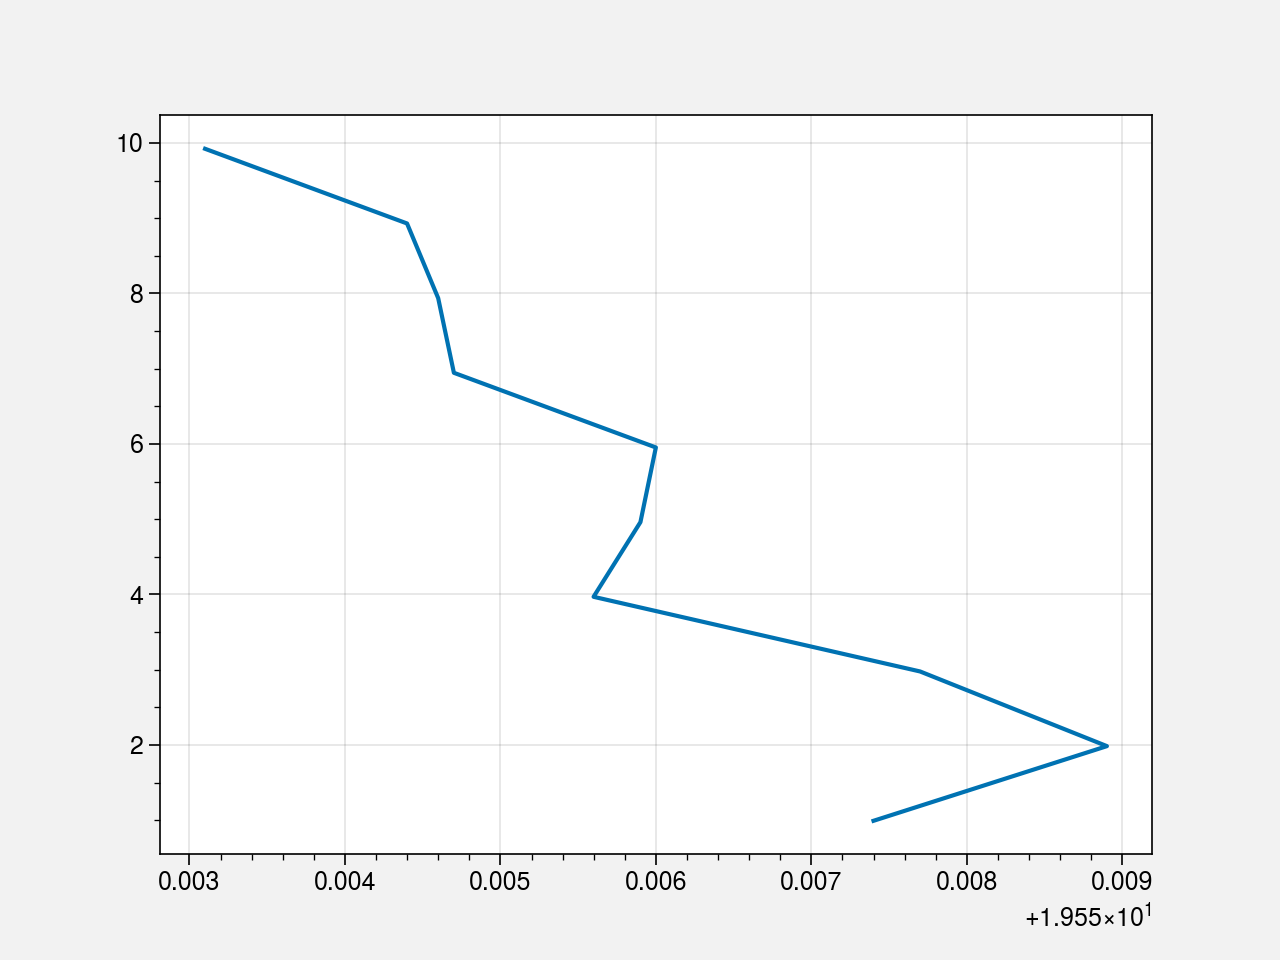

In [35]:
i_cast = 20

T = CODA_output_dataset['Temperature'][i_cast]
z = CODA_output_dataset['z'][i_cast]

nan_mask = T==FILL_VALUE
T[nan_mask] = np.nan
z[nan_mask] = np.nan
plt.plot(T,-z)

In [6]:
vars_to_get = ['z','Temperature','Salinity'] #,'latitude','longitude','time']
  
data_container = {}

for i_var in vars_to_get:
    data_container[i_var] = []
    data_container[i_var+'_qc_flag'] = []
    data_container[i_var+'_sd_test'] = []

    

data_container['latitude']  = []
data_container['longitude'] = []
data_container['time']      = []

    
ancillary_vars_to_get = ['origflagset','country','dataset','Access_no','Recorder',
                         'dbase_orig','Platform','Project','WOD_cruise_identifier',
                         'Institute','Ocean_Vehicle']

    
latitudes = []
longitudes = []

FILL_VALUE = -9999

for i_file in ran_ctd_files_to_get:
    #print(i_file)
    ran_ctd_dataset = xarray.open_dataset(i_file)
    
    vars_in_dataset = ran_ctd_dataset.variables.keys()
    for i_var in vars_to_get:
        if CODA_to_mnf_key[i_var] in vars_in_dataset:
            current_profile = ran_ctd_dataset[CODA_to_mnf_key[i_var]].values
        else: 
            current_profile = [np.nan]
            
        data_container[i_var].append(current_profile)
    data_container['latitude'].append(ran_ctd_dataset[CODA_to_mnf_key['latitude']].values)
    data_container['longitude'].append(ran_ctd_dataset[CODA_to_mnf_key['longitude']].values)
    data_container['time'].append(ran_ctd_dataset[CODA_to_mnf_key['time']].values)

    data_container['z'][-1] = TEOS_10.z_from_p(data_container['z'][-1],data_container['latitude'][-1])

    ran_ctd_dataset.close()
    

In [51]:
data_container['latitude'][-1]

IndexError: list index out of range

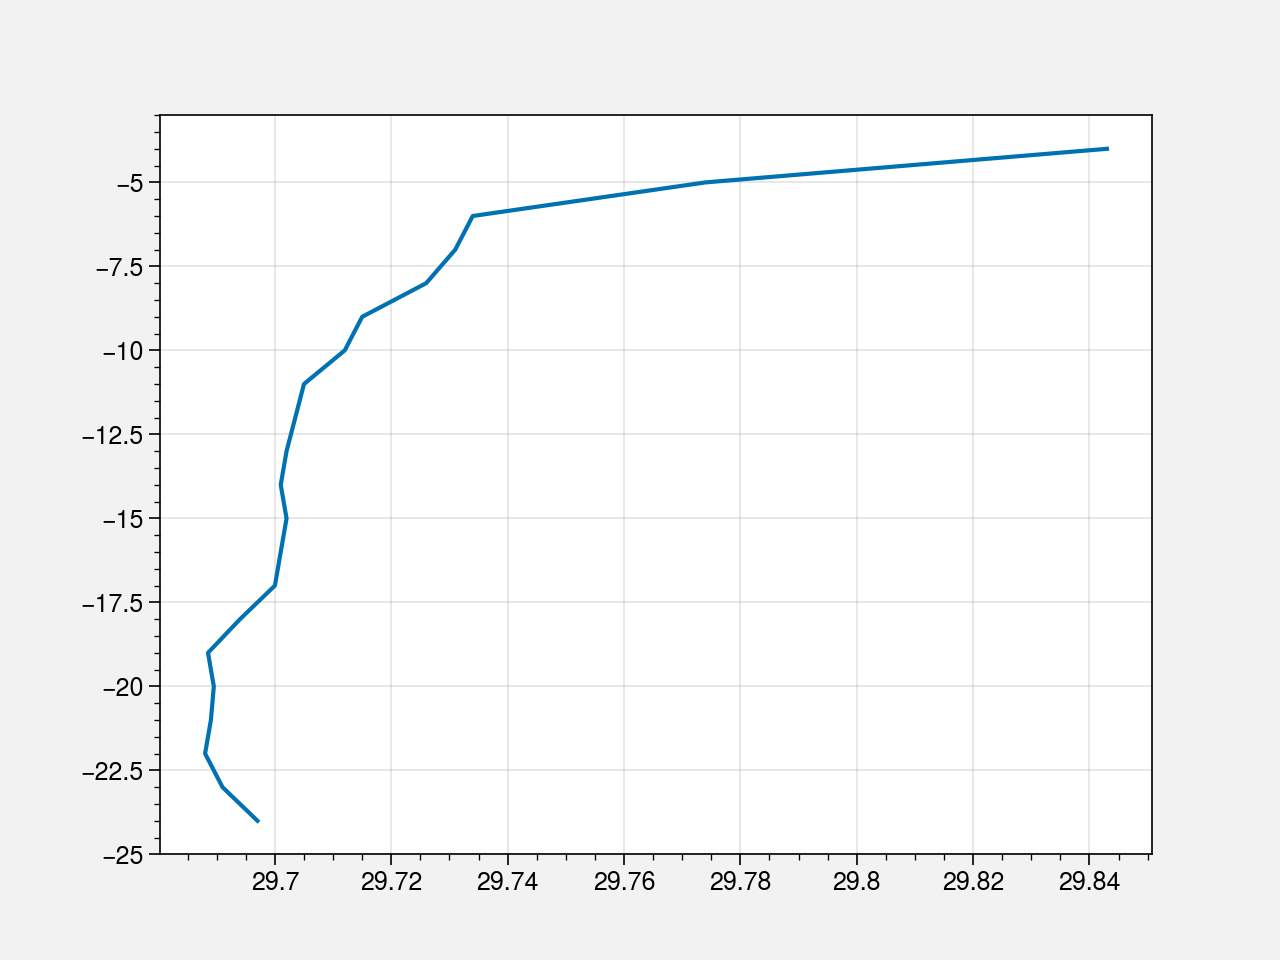

In [47]:
i_cast = 4000
plt.plot(data_container['Temperature'][i_cast],-data_container['z'][i_cast])

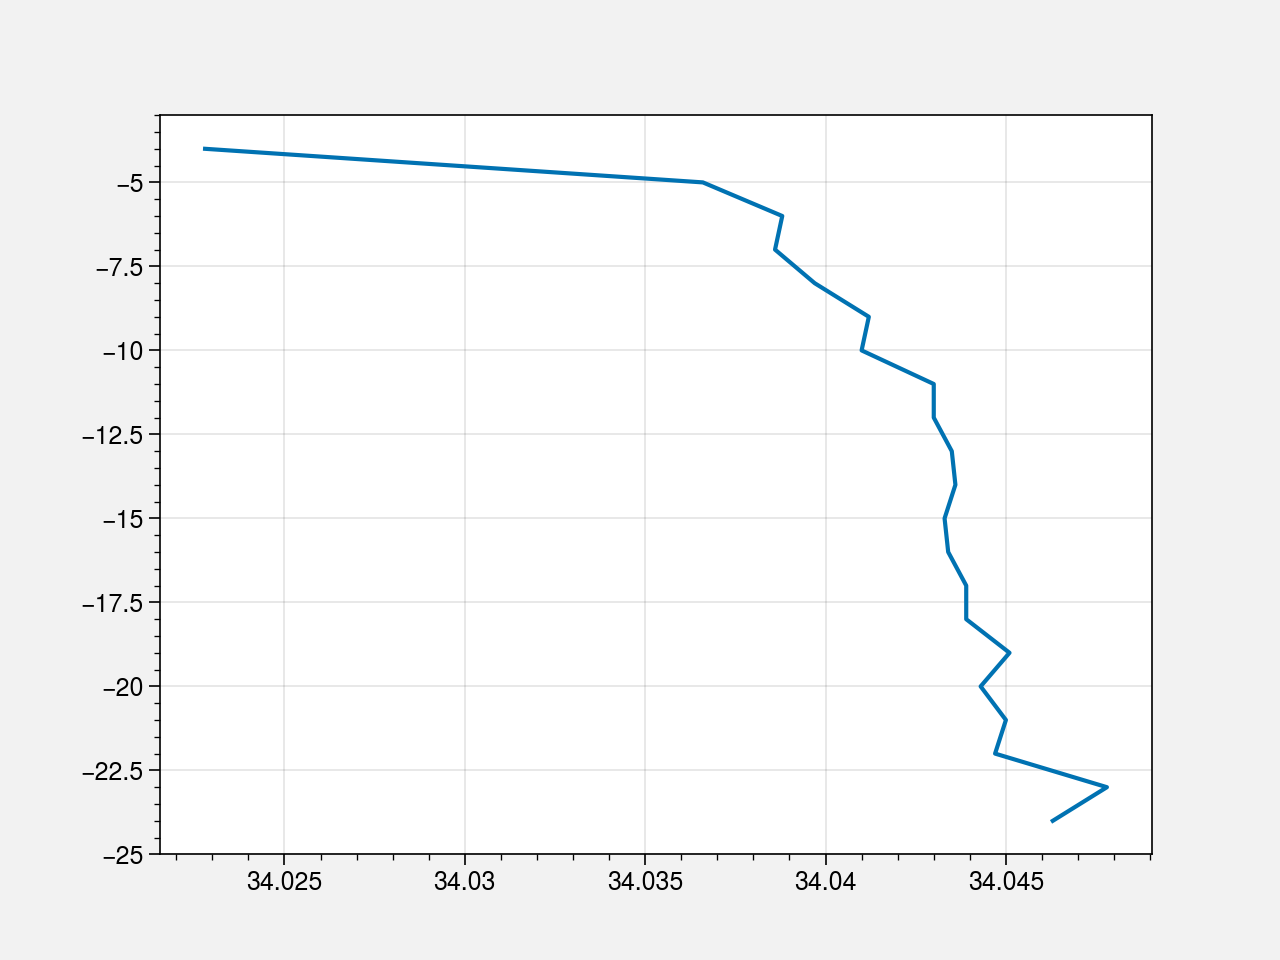

In [48]:
i_cast = 4000
plt.plot(data_container['Salinity'][i_cast],-data_container['z'][i_cast])